In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# ------------------ Configuration ------------------

# Load CSVs
predictions_baseline = pd.read_csv("Results/model_predictions.csv (21-window).csv")
predictions_chronos = pd.read_csv("Results/chronos(21-day).csv")
predictions_timesfm = pd.read_csv("Results/timesfm(21-day).csv")
predictions_uni2ts = pd.read_csv("Results/uni2ts(21-day)predictions.csv")

# Convert 'DlyCalDt' to datetime
for df in [predictions_baseline, predictions_chronos, predictions_timesfm, predictions_uni2ts]:
    df['DlyCalDt'] = pd.to_datetime(df['DlyCalDt'])

# Sort by date
for df in [predictions_baseline, predictions_chronos, predictions_timesfm, predictions_uni2ts]:
    df.sort_values(by=["DlyCalDt", "PERMNO"], inplace=True, ignore_index=True)

# Combine all predictions into a single DataFrame
exclude_columns = ['DlyCalDt', 'PERMNO', 'ExcessReturn']

baseline_cols = predictions_baseline.columns.tolist()
chronos_cols = [cols for cols in predictions_chronos.columns.tolist() if cols not in exclude_columns]
timesfm_cols = [cols for cols in predictions_timesfm.columns.tolist() if cols not in exclude_columns]
uni2ts_cols = [cols for cols in predictions_uni2ts.columns.tolist() if cols not in exclude_columns] 

# Concatenate along axis=1 (columns), aligned by index
combined_df = pd.concat([
    predictions_baseline[baseline_cols],
    predictions_chronos[chronos_cols],
    predictions_timesfm[timesfm_cols],
    predictions_uni2ts[uni2ts_cols]
], axis=1)

combined_df.rename(columns={
    'DlyCalDt': 'Date',
    'ExcessReturn': 'Actual'
}, inplace=True)

In [2]:
combined_df

,PERMNO,Date,Actual,Ridge,OLS,ElasticNet,Lasso,GLM,RF,NN1,...,y_chr_bolt_small,y_chr_bolt_base,y_chr_t5_tiny,y_chr_t5_mini,y_chr_t5_small,y_tfm1,y_tfm2,y_moirai_s,y_moirai_moe_s,y_moirai_moe_b
0,10138,2016-01-04,-0.018191,0.000935,0.000935,0.000924,0.000678,0.000789,0.000455,0.002163,...,-0.005876,-0.004940,0.001673,0.001457,-0.001117,-0.003183,-0.003169,-0.002905,-0.000002,-0.002632
1,17778,2016-01-04,-0.007616,0.000226,0.000226,0.000622,0.000718,0.000396,0.000455,0.002163,...,-0.006515,-0.005731,0.000397,-0.000885,-0.002104,-0.001918,-0.007620,0.005616,0.002744,0.002177
2,28388,2016-01-04,-0.015413,0.000477,0.000477,0.000848,0.000724,0.000364,0.000455,0.002163,...,-0.005211,-0.004785,-0.001482,-0.001674,-0.001709,-0.001897,-0.013042,-0.000540,-0.002290,0.004907
3,34746,2016-01-04,-0.027370,-0.000371,-0.000371,0.000470,0.000666,-0.000256,0.000455,0.002163,...,-0.006322,-0.006360,-0.005600,0.003400,-0.002636,-0.000446,-0.006784,0.003879,0.006690,0.005031
4,35044,2016-01-04,-0.016674,-0.000457,-0.000457,0.000435,0.000637,-0.000379,0.000455,0.002163,...,-0.004964,-0.005522,-0.002721,0.000552,-0.001344,-0.000691,0.000836,0.009372,0.010487,0.005235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112395,86455,2024-12-31,0.000924,-0.000188,-0.000188,0.000831,0.000696,0.000134,0.000455,0.002163,...,-0.005856,-0.004027,-0.002792,-0.003121,-0.003048,-0.001406,-0.012584,0.002012,-0.002734,0.151252
112396,86755,2024-12-31,-0.008607,0.001078,0.001078,0.001012,0.000744,0.001458,0.000455,0.002163,...,-0.005890,-0.004680,-0.000193,-0.000987,-0.000652,-0.002456,-0.016244,0.004934,-0.004203,-0.002197
112397,86868,2024-12-31,-0.001733,-0.000053,-0.000053,0.000686,0.000630,0.000106,0.000455,0.002163,...,-0.003259,-0.002465,-0.001720,-0.001184,-0.002174,-0.003298,-0.001841,0.007567,-0.002170,0.003662
112398,87267,2024-12-31,-0.002370,0.000737,0.000737,0.000754,0.000780,0.000262,0.000455,0.002163,...,-0.011086,-0.008270,-0.001877,-0.004184,-0.002601,-0.003936,-0.016902,0.000469,0.001438,0.000820


### Sharpe Ratio for actual returns: 0.4552


In [3]:

def build_long_short_portfolio(df, column_name, n=10):
    
    long_short_returns = []
    
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(column_name, ascending=False)
        no_of_stocks = round((n/100)*len(sorted_group))
        top = sorted_group.head(no_of_stocks)
        bottom = sorted_group.tail(no_of_stocks)
        avg_return = top['Actual'].mean() - bottom['Actual'].mean()
        long_short_returns.append((date, avg_return))
    
    return pd.DataFrame(long_short_returns, columns=["Date", "Returns"])

In [4]:
model_cols = [
    'Ridge', 'OLS', 'ElasticNet', 'Lasso', 'GLM', 'RF',
    'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'GBRT',
    'y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
    'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small',
    'y_tfm1', 'y_tfm2',
    'y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b'
]

portfolio_returns = {}

for model in model_cols:
    ls_df = build_long_short_portfolio(combined_df, model)
    ls_df.set_index('Date', inplace=True)
    portfolio_returns[model] = ls_df['Returns']

# Combine all into one DataFrame
portfolio_df = pd.DataFrame(portfolio_returns)
portfolio_df

,Ridge,OLS,ElasticNet,Lasso,GLM,RF,NN1,NN2,NN3,NN4,...,y_chr_bolt_small,y_chr_bolt_base,y_chr_t5_tiny,y_chr_t5_mini,y_chr_t5_small,y_tfm1,y_tfm2,y_moirai_s,y_moirai_moe_s,y_moirai_moe_b
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.001275,0.001275,-0.003913,-0.011359,-0.004656,-0.004005,0.006765,-0.007137,-0.008995,-0.011642,...,0.020805,0.012551,0.015042,0.010098,0.007662,0.014525,-0.005112,0.000960,0.004614,0.005750
2016-01-05,-0.019369,-0.019369,-0.016572,-0.004539,-0.012975,0.007675,0.005159,0.002165,-0.006055,0.009749,...,0.007514,0.001534,0.004165,0.001836,0.010128,0.007456,-0.010313,-0.014819,-0.013730,-0.017160
2016-01-06,-0.008811,-0.008811,-0.013693,-0.012583,-0.006120,0.002829,0.014525,0.007511,0.003495,0.006125,...,0.011920,0.015099,0.011467,0.004401,0.010577,0.012703,0.016462,0.001853,0.004772,0.001252
2016-01-07,-0.008540,-0.008540,-0.016242,-0.019752,-0.012542,0.003383,-0.004152,0.000512,0.003113,0.019897,...,0.017174,0.006007,0.019322,0.009529,0.013392,0.001191,0.012960,0.002255,-0.005720,-0.008501
2016-01-08,0.002384,0.002384,0.000117,0.000025,-0.001919,-0.002843,-0.005213,0.000511,-0.003373,0.006207,...,0.001876,-0.004481,0.002477,0.003427,0.009063,-0.004553,-0.003096,-0.009082,-0.008122,0.000381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.004791,0.004791,0.007947,0.010626,0.005826,-0.004672,-0.004404,-0.004637,0.009430,0.002294,...,0.002207,-0.007308,-0.000502,-0.001710,0.002724,0.001074,0.000181,-0.002524,-0.001323,-0.007329
2024-12-26,-0.003031,-0.003031,0.003441,0.000449,-0.002556,-0.002691,0.005930,-0.002102,0.002884,-0.003449,...,-0.000585,-0.003705,-0.003592,-0.003347,0.000134,0.001308,0.001519,0.000655,-0.001919,0.003993
2024-12-27,-0.009530,-0.009530,0.001269,0.000951,-0.008110,-0.003535,-0.004992,0.002336,-0.000369,-0.001521,...,-0.003219,-0.002230,0.002526,-0.003471,-0.002680,0.003346,-0.004664,-0.003745,0.001337,0.001396


In [5]:
# Compute cumulative returns for each model (assuming daily returns)
cumulative_returns = portfolio_df.cumsum()

# Download S&P 500 daily close prices over the same date range
sp500 = yf.download("^GSPC", start=portfolio_df.index.min(), end=portfolio_df.index.max())

# Calculate daily returns of S&P 500
sp500['Return'] = sp500['Close'].pct_change()

# Calculate cumulative returns
sp500['Cumulative Return'] = sp500['Return'].cumsum()

# Calculate compounded returns
sp500['Compounded Returns'] = (1+sp500['Return']).cumprod()


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\3246528272.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=portfolio_df.index.min(), end=portfolio_df.index.max())
[*********************100%***********************]  1 of 1 completed


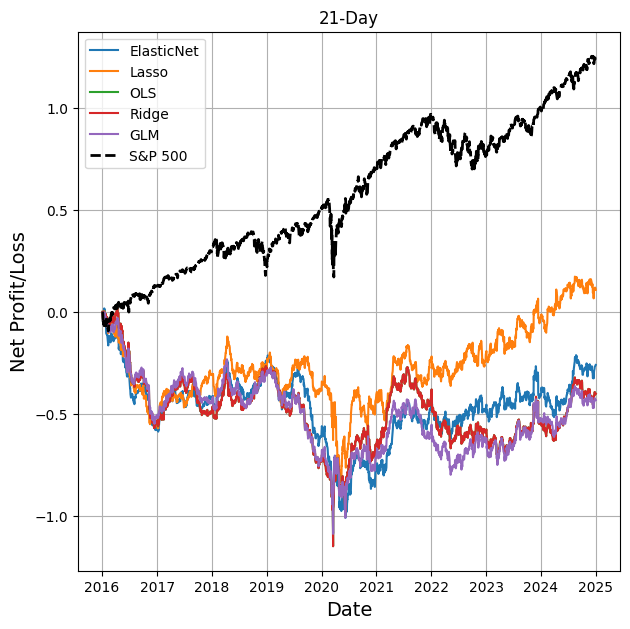

In [6]:
# Plotting returns of linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

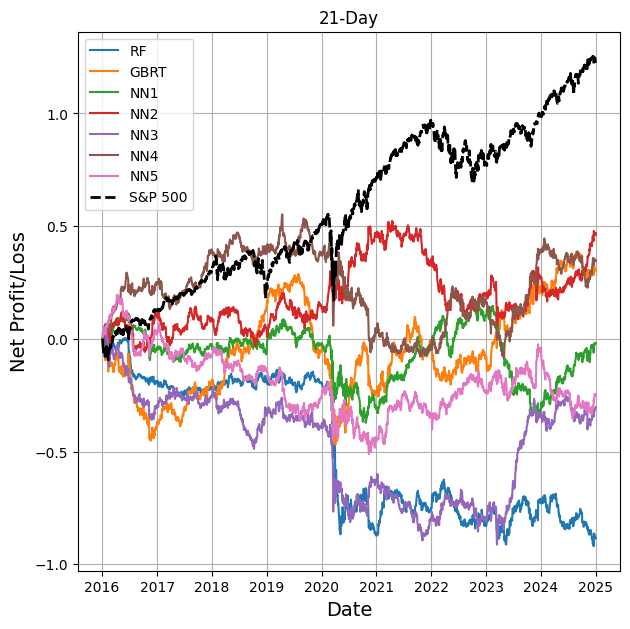

In [8]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

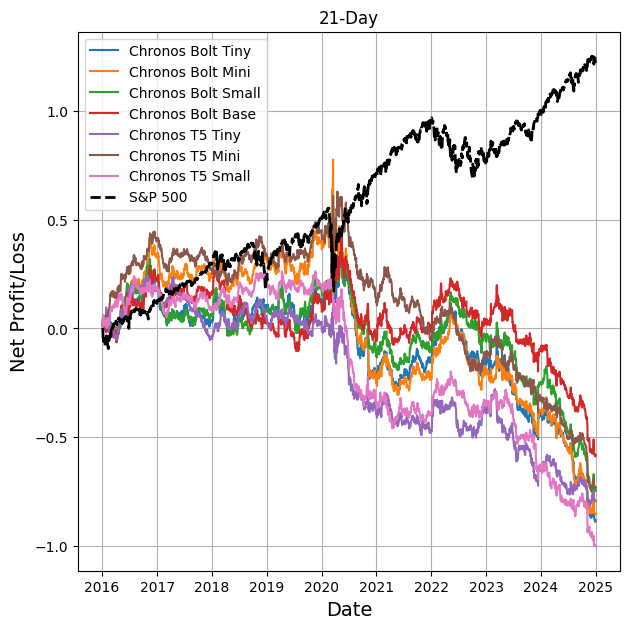

In [9]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(7,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


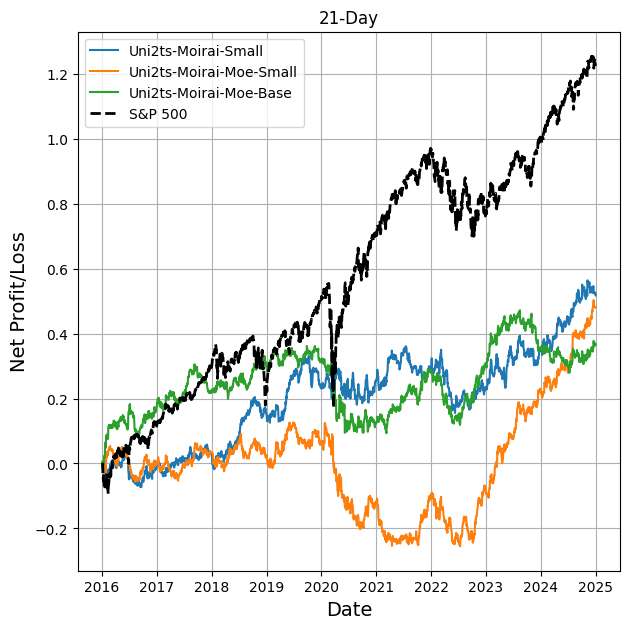

In [10]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


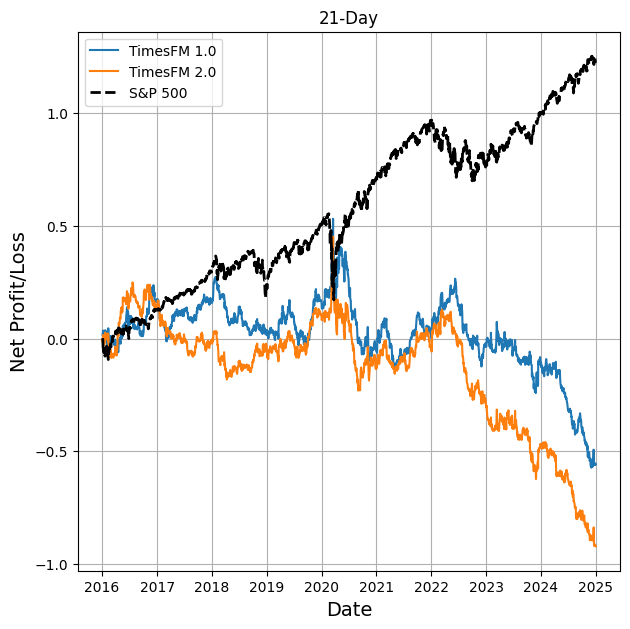

In [11]:
# Plotting returns of TimesFM models vs S&P 500

plt.figure(figsize=(7,7))

timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

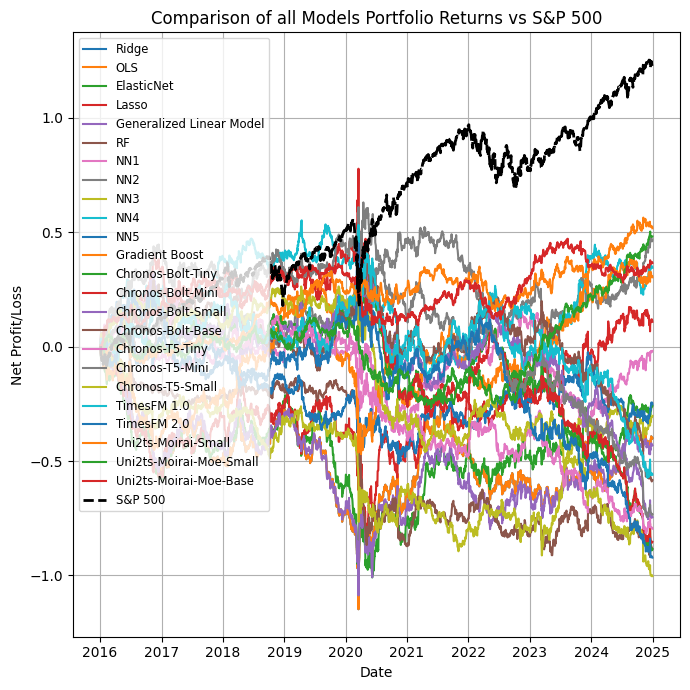

In [12]:
# Plotting returns of all models vs S&P 500

plt.figure(figsize=(7,7))

models_dict = {"OLS": "OLS",
               "Lasso": "Lasso",
               "Ridge": "Ridge",
               "ElasticNet": "ElasticNet",
               "RF": "RF",
               "GLM": "Generalized Linear Model",
               "GBRT": "Gradient Boost",
               "NN1": "NN1",
               "NN2": "NN2",
               "NN3": "NN3",
               "NN4": "NN4",
               "NN5": "NN5",
               "y_chr_bolt_tiny": "Chronos-Bolt-Tiny",
               "y_chr_bolt_mini": "Chronos-Bolt-Mini",
               "y_chr_bolt_small": "Chronos-Bolt-Small",
               "y_chr_bolt_base": "Chronos-Bolt-Base",
               "y_chr_t5_tiny": "Chronos-T5-Tiny",
               "y_chr_t5_mini": "Chronos-T5-Mini",
               "y_chr_t5_small": "Chronos-T5-Small",
               "y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0",
               "y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
               }

# Portfolios
for col in model_cols:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=models_dict[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Comparison of all Models Portfolio Returns vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Net Profit/Loss")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

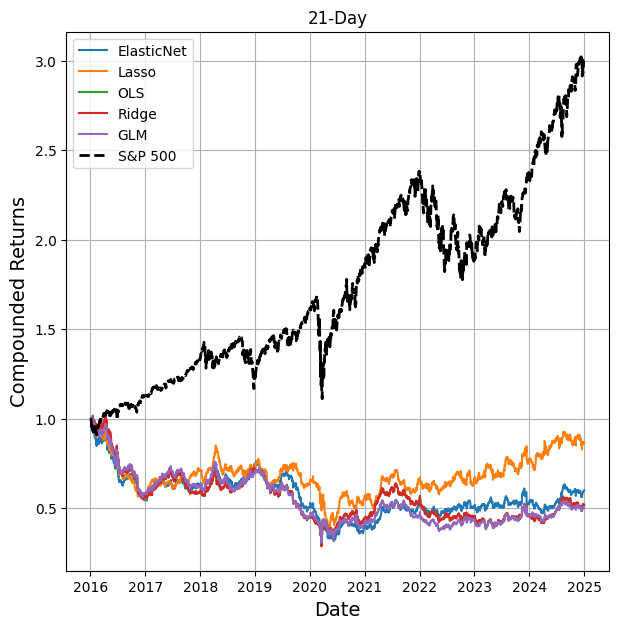

In [13]:
# Plotting compounded returns of linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

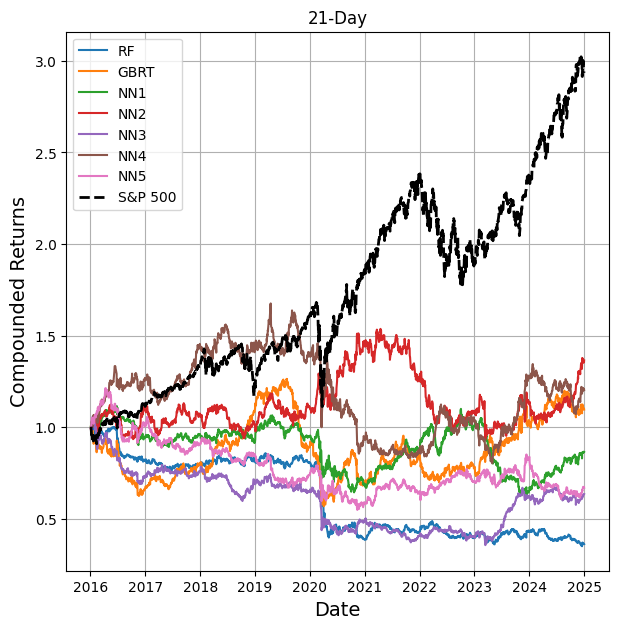

In [14]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

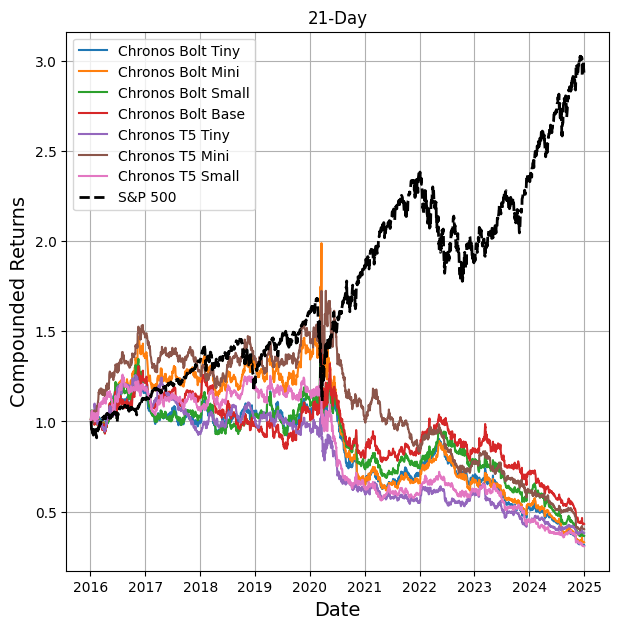

In [15]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(7,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


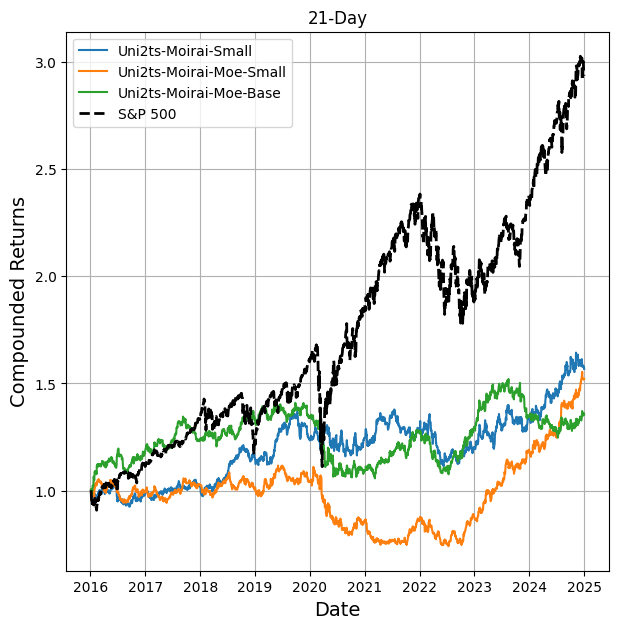

In [16]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


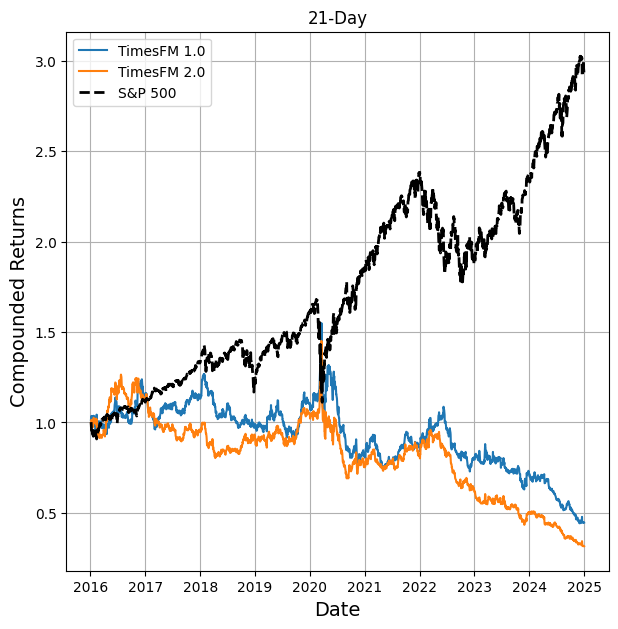

In [17]:
# Plotting returns of TimesFM models vs S&P 500

plt.figure(figsize=(7,7))

timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

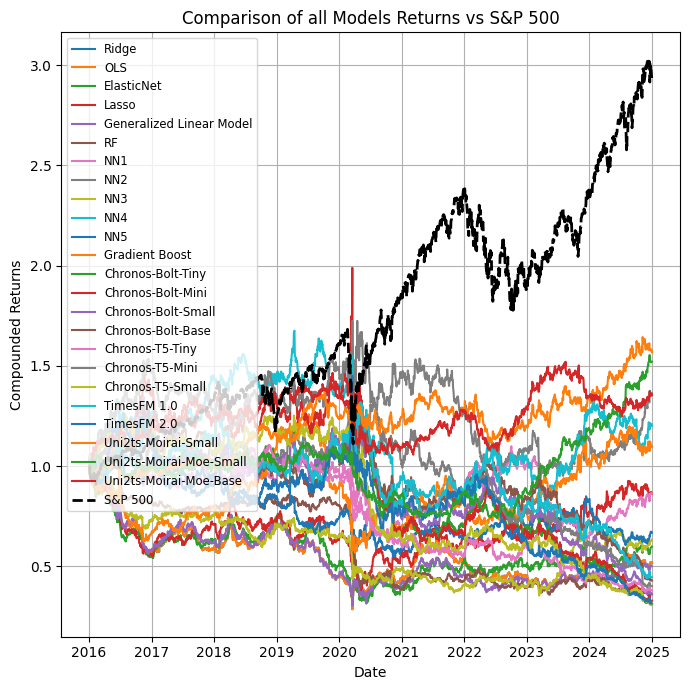

In [18]:
# Plotting returns of all models vs S&P 500

plt.figure(figsize=(7,7))

models_dict = {"OLS": "OLS",
               "Lasso": "Lasso",
               "Ridge": "Ridge",
               "ElasticNet": "ElasticNet",
               "RF": "RF",
               "GLM": "Generalized Linear Model",
               "GBRT": "Gradient Boost",
               "NN1": "NN1",
               "NN2": "NN2",
               "NN3": "NN3",
               "NN4": "NN4",
               "NN5": "NN5",
               "y_chr_bolt_tiny": "Chronos-Bolt-Tiny",
               "y_chr_bolt_mini": "Chronos-Bolt-Mini",
               "y_chr_bolt_small": "Chronos-Bolt-Small",
               "y_chr_bolt_base": "Chronos-Bolt-Base",
               "y_chr_t5_tiny": "Chronos-T5-Tiny",
               "y_chr_t5_mini": "Chronos-T5-Mini",
               "y_chr_t5_small": "Chronos-T5-Small",
               "y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0",
               "y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
               }

# Portfolios
for col in model_cols:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=models_dict[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Comparison of all Models Returns vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Compounded Returns")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Function to calculate performance metrics

def performance_metrics(df, column_name):
    returns = df[column_name]

    avg_daily_return = returns.mean()
    ann_return = avg_daily_return * 252
    daily_vol = returns.std()
    ann_vol = daily_vol * np.sqrt(252)
    sharpe = avg_daily_return / daily_vol * np.sqrt(252)

    return {
        'Avg Daily Return': avg_daily_return,
        'Annualized Return': ann_return,
        'Daily Volatility': daily_vol,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe    
        }


In [8]:
metrics_dict = {}

for model in model_cols:
    metrics = performance_metrics(portfolio_df, model)
    metrics_dict[model] = {k: v for k, v in metrics.items()}

# Create summary DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

metrics_df

,Avg Daily Return,Annualized Return,Daily Volatility,Annualized Volatility,Sharpe Ratio
Ridge,-0.000178,-0.044843,0.015134,0.240249,-0.186652
OLS,-0.000178,-0.044843,0.015134,0.240249,-0.186652
ElasticNet,-0.000115,-0.029068,0.015048,0.238875,-0.121687
Lasso,0.000048,0.012184,0.015155,0.240572,0.050646
GLM,-0.000192,-0.048297,0.015168,0.240779,-0.200587
RF,-0.000394,-0.099267,0.010889,0.172852,-0.574290
NN1,-0.000008,-0.002132,0.010612,0.168460,-0.012653
NN2,0.000209,0.052581,0.011843,0.188003,0.279679
NN3,-0.000135,-0.033908,0.011629,0.184601,-0.183680
NN4,0.000153,0.038644,0.011931,0.189393,0.204040


In [13]:
import pandas as pd
import numpy as np

def calculate_long_short_returns(df, model_col, n=10):
    long_short_returns = []
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(model_col, ascending=False)
        no_of_stocks = round((n / 100) * len(sorted_group))
        top = sorted_group.head(no_of_stocks)
        bottom = sorted_group.tail(no_of_stocks)
        avg_return = top['Actual'].mean() - bottom['Actual'].mean()
        long_short_returns.append((date, avg_return))
    return pd.DataFrame(long_short_returns, columns=['Date', 'Returns']).set_index('Date')

def calculate_daily_weights(df, model_col, n=10):
    weights_dict = {}
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(model_col, ascending=False)
        no_of_stocks = round((n / 100) * len(sorted_group))
        weights = pd.Series(0, index=sorted_group['PERMNO'])
        weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks
        weights.loc[sorted_group.tail(no_of_stocks)['PERMNO']] = -1 / no_of_stocks
        weights_dict[date] = weights
    weights_df = pd.DataFrame(weights_dict).T.fillna(0)
    return weights_df

def calculate_daily_turnover(weights_df):
    turnover_list = []
    prev_weights = None
    for date, weights in weights_df.iterrows():
        if prev_weights is None:
            turnover = 0
        else:
            turnover = ((weights - prev_weights).abs().sum()) / 2
        turnover_list.append((date, turnover))
        prev_weights = weights
    turnover_df = pd.DataFrame(turnover_list, columns=['Date', 'Turnover']).set_index('Date')
    return turnover_df

def adjust_returns_with_costs(returns_df, turnover_df, transaction_cost_per_trade=0.0015):
    df = returns_df.copy()
    df = df.join(turnover_df, how='left')
    df['Transaction_Cost'] = transaction_cost_per_trade * df['Turnover']
    df['Returns_Adj'] = df['Returns'] - df['Transaction_Cost']
    return df

def performance_metrics(df, return_col='Returns_Adj'):
    returns = df[return_col].dropna()
    avg_daily_return = returns.mean()
    annualized_return = avg_daily_return * 252
    daily_volatility = returns.std()
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
    metrics = {
        'Avg Daily Return': avg_daily_return,
        'Annualized Return': annualized_return,
        'Daily Volatility': daily_volatility,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    }
    return metrics

# Your list of model columns
model_cols = ['Ridge', 'OLS', 'ElasticNet', 'Lasso', 'GLM', 'RF', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'GBRT', 
              'y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
              'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small',
              'y_tfm1', 'y_tfm2',
              'y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b']

transaction_cost_per_trade = 0.0002  # 15 bps
n = 10  # top/bottom 10% stocks for long-short

all_metrics = {}
returns_adj_dfs = pd.DataFrame()

for model in model_cols:
    print(f"Processing model: {model}")
    returns_df = calculate_long_short_returns(combined_df, model, n=n)
    weights_df = calculate_daily_weights(combined_df, model, n=n)
    turnover_df = calculate_daily_turnover(weights_df)
    returns_adj_df = adjust_returns_with_costs(returns_df, turnover_df, transaction_cost_per_trade)
    metrics = performance_metrics(returns_adj_df, return_col='Returns_Adj')
    all_metrics[model] = metrics
    returns_adj_dfs[model] = returns_adj_df['Returns_Adj']


# Convert dict of dicts to DataFrame for easier viewing
metrics_df_adj = pd.DataFrame.from_dict(all_metrics, orient='index')
metrics_df_adj = metrics_df_adj.sort_values(by='Sharpe Ratio', ascending=False)

print(metrics_df_adj)


Processing model: Ridge


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: OLS


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: ElasticNet


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: Lasso


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: GLM


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: RF


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN1


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN2


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN3


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN4


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN5


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: GBRT


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_tiny


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_mini


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_small


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_base


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_t5_tiny


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_t5_mini


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_t5_small


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_tfm1


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_tfm2


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_moirai_s


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_moirai_moe_s


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_moirai_moe_b


C:\Users\amaan\AppData\Local\Temp\ipykernel_21072\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


                  Avg Daily Return  Annualized Return  Daily Volatility  \
NN2                      -0.000122          -0.030678          0.011844   
GBRT                     -0.000190          -0.047797          0.013678   
NN4                      -0.000177          -0.044664          0.011930   
y_moirai_s               -0.000126          -0.031641          0.007773   
y_moirai_moe_s           -0.000141          -0.035441          0.007442   
Lasso                    -0.000296          -0.074648          0.015155   
NN1                      -0.000241          -0.060800          0.010615   
y_moirai_moe_b           -0.000192          -0.048463          0.007416   
ElasticNet               -0.000451          -0.113555          0.015047   
Ridge                    -0.000485          -0.122129          0.015135   
OLS                      -0.000485          -0.122129          0.015135   
GLM                      -0.000507          -0.127807          0.015169   
y_tfm1                   

In [14]:
metrics_df_adj

,Avg Daily Return,Annualized Return,Daily Volatility,Annualized Volatility,Sharpe Ratio
NN2,-0.000122,-0.030678,0.011844,0.188014,-0.163169
GBRT,-0.000190,-0.047797,0.013678,0.217129,-0.220130
NN4,-0.000177,-0.044664,0.011930,0.189383,-0.235841
y_moirai_s,-0.000126,-0.031641,0.007773,0.123396,-0.256420
y_moirai_moe_s,-0.000141,-0.035441,0.007442,0.118138,-0.299995
Lasso,-0.000296,-0.074648,0.015155,0.240585,-0.310278
NN1,-0.000241,-0.060800,0.010615,0.168513,-0.360803
y_moirai_moe_b,-0.000192,-0.048463,0.007416,0.117731,-0.411641
ElasticNet,-0.000451,-0.113555,0.015047,0.238859,-0.475407
Ridge,-0.000485,-0.122129,0.015135,0.240264,-0.508311


In [23]:
# Rename columns to corresponding models

returns_adj_dfs

,Ridge,OLS,ElasticNet,Lasso,GLM,RF,NN1,NN2,NN3,NN4,...,y_chr_bolt_small,y_chr_bolt_base,y_chr_t5_tiny,y_chr_t5_mini,y_chr_t5_small,y_tfm1,y_tfm2,y_moirai_s,y_moirai_moe_s,y_moirai_moe_b
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.001275,0.001275,-0.003913,-0.011359,-0.004656,-0.004005,0.006765,-0.007137,-0.008995,-0.011642,...,0.020805,0.012551,0.015042,0.010098,0.007662,0.014525,-0.005112,0.000960,0.004614,0.005750
2016-01-05,-0.022069,-0.022069,-0.018972,-0.006639,-0.015375,0.006775,0.003059,-0.000535,-0.008455,0.007049,...,0.005714,-0.000566,0.002665,0.000036,0.008628,0.005956,-0.013013,-0.017819,-0.016130,-0.020160
2016-01-06,-0.011211,-0.011211,-0.016093,-0.014983,-0.008820,0.001929,0.012725,0.005111,0.000795,0.003425,...,0.010120,0.012999,0.009667,0.002001,0.008777,0.011503,0.013762,-0.000847,0.002072,-0.001148
2016-01-07,-0.010040,-0.010040,-0.018042,-0.021852,-0.014642,0.002783,-0.006852,-0.002188,0.000413,0.017497,...,0.015974,0.005107,0.017822,0.007429,0.012192,0.000591,0.011160,-0.000745,-0.008720,-0.010901
2016-01-08,-0.000016,-0.000016,-0.001683,-0.002375,-0.004319,-0.004343,-0.006713,-0.002489,-0.005773,0.003507,...,-0.000824,-0.007181,0.001577,0.001627,0.007563,-0.006653,-0.005496,-0.012082,-0.011122,-0.001719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.002091,0.002091,0.005247,0.008226,0.003126,-0.005572,-0.006804,-0.007337,0.006730,-0.000106,...,-0.000493,-0.009108,-0.003202,-0.004110,0.000624,-0.001026,-0.002519,-0.005224,-0.004023,-0.010329
2024-12-26,-0.005731,-0.005731,0.001041,-0.002551,-0.004956,-0.004191,0.003230,-0.004202,-0.000116,-0.006149,...,-0.002985,-0.006105,-0.005392,-0.005147,-0.001366,-0.001392,-0.001481,-0.001445,-0.004619,0.001593
2024-12-27,-0.011630,-0.011630,-0.001731,-0.001449,-0.009910,-0.005035,-0.007392,-0.000664,-0.002769,-0.003621,...,-0.005319,-0.004630,0.000426,-0.005571,-0.004180,0.001846,-0.006764,-0.006745,-0.001663,-0.001604


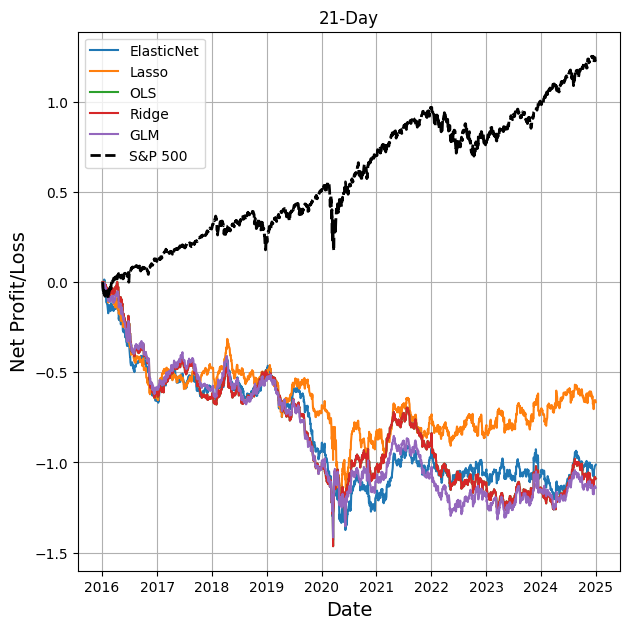

In [15]:
# Plotting returns of linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

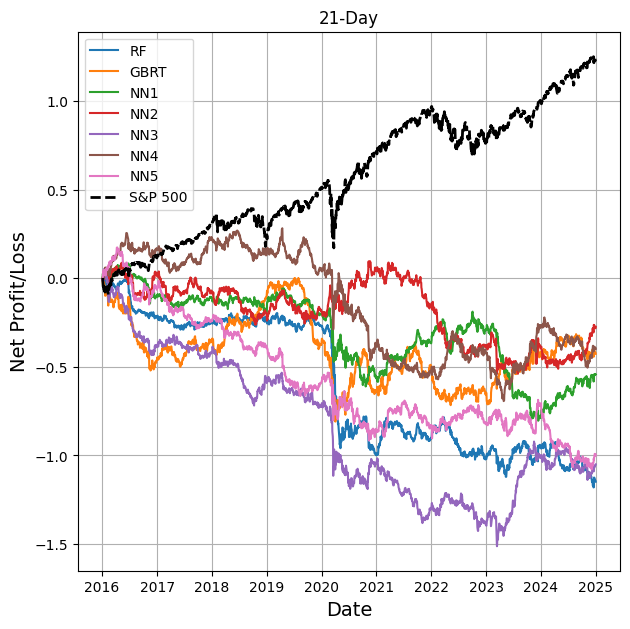

In [16]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

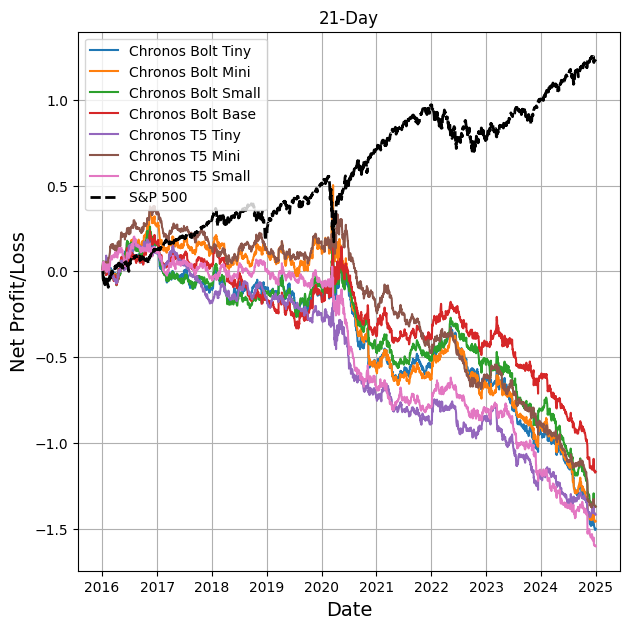

In [17]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(7,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

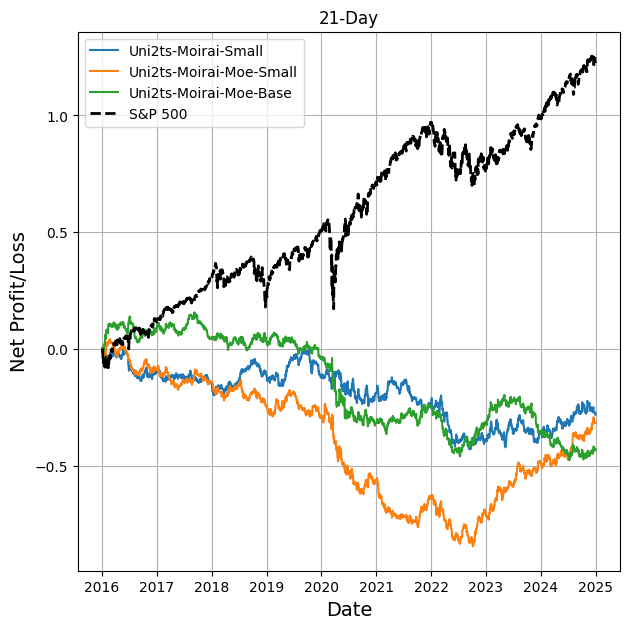

In [18]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Uni2ts-Moirais Models Portfolio Returns")
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


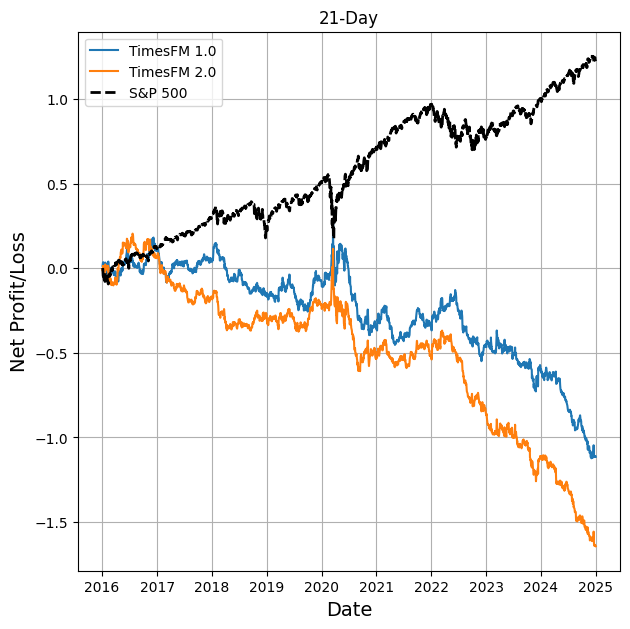

In [20]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("21-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()